In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import seaborn as sns


In [33]:
def load_data_by_dimension(dimension):
    root="./datasets/"
    data_filename = root+f'kryptonite-{dimension}-X.npy'
    labels_filename = root+f'kryptonite-{dimension}-y.npy'

    try:
        data = np.load(data_filename)
        labels = np.load(labels_filename)
        print(f"Loaded dataset with dimension {dimension}. Data shape: {data.shape}, Labels shape: {labels.shape}")
        return data, labels
    except FileNotFoundError:
        print(f"Dataset for dimension {dimension} not found.")
        return None, None

# Experiment1: KNN Performance

## Grid Search

In [38]:
def find_best_knn_params(data, labels,search_grid=np.arange(1,30,2)):
    # Define the parameter grid for k in kNN
    param_grid = {'n_neighbors': search_grid,'weights':["uniform","distance"]}
    # Initialize the KNeighborsClassifier
    knn = KNeighborsClassifier()
    # Use GridSearchCV to find the best parameter
    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(data, labels)
    return grid_search.best_params_['n_neighbors'], grid_search.best_score_,grid_search.best_params_['weights']

In [39]:
dimensions = [9,12,15,18,24,30,45]
best_ks = []
accuracies = []
weights=[]
for dim in dimensions:
    data, labels = load_data_by_dimension(dim)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    # find best k
    best_k, best_acc,w = find_best_knn_params(X_train, y_train)
    print(f"Best k for dimension {dim}: {best_k}, weight: {w} with accuracy {best_acc}")
    best_ks.append(best_k)
    weights.append(w)

print(best_ks)
print(weights)

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Best k for dimension 9: 9, weight: uniform with accuracy 0.9584722222222222
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Best k for dimension 12: 1, weight: uniform with accuracy 0.9111979166666666
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Best k for dimension 15: 3, weight: distance with accuracy 0.508375
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Best k for dimension 18: 29, weight: distance with accuracy 0.5305208333333333
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Best k for dimension 24: 3, weight: distance with accuracy 0.5038020833333333
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Best k for dimension 30: 7, weight: uniform with accuracy 0.5064583333333333
Loaded dataset with dimension 45. Data shape: (90000, 4

## Evaluation

In [41]:
dimensions=[9,12,15,18,24,30,45]
means = []
std_devs = []
random_seeds = [42, 123, 456, 789, 1010, 2020, 3030, 4040, 5050, 6060]
for dim, k, w in zip(dimensions,best_ks,weights):
  data, labels = load_data_by_dimension(dim)
  accuracies = []
  for seed in random_seeds:
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,random_state=seed)

    model = KNeighborsClassifier(n_neighbors=k,weights=w)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
  means.append(np.mean(accuracies))
  std_devs.append(np.std(accuracies))

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


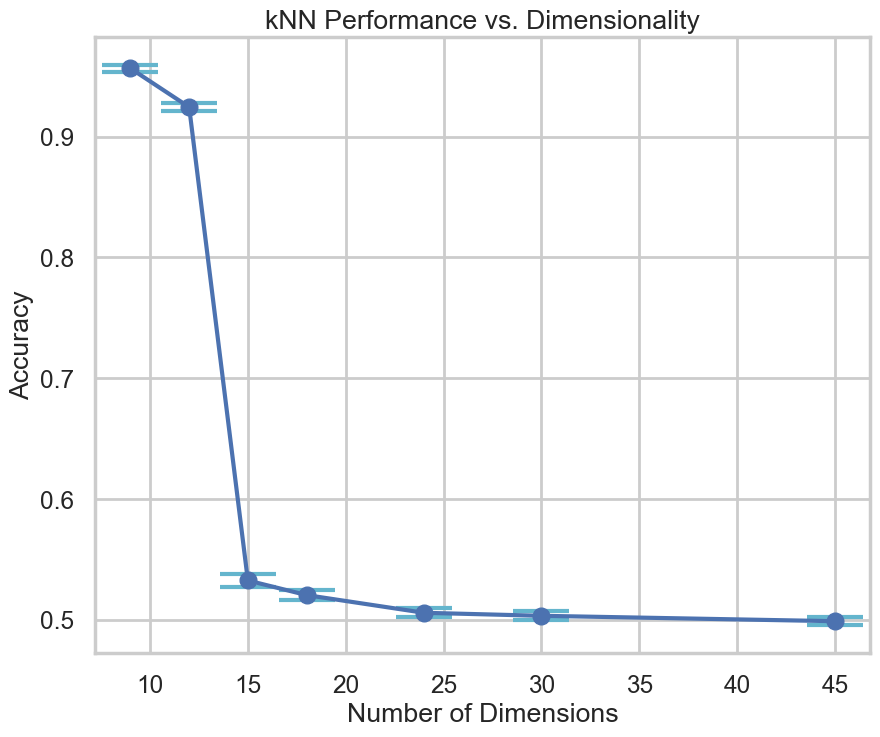

In [44]:
plt.rcdefaults()
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=0.8)
plt.errorbar(dimensions, means, yerr=std_devs, marker='o', linestyle='-', color='b', ecolor='c', capsize=20, capthick=3)
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy')
plt.title('kNN Performance vs. Dimensionality')
plt.grid(True)
plt.show()

# Experiment2: KNN with Feature Selection

## Experiment with different variance threshold

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


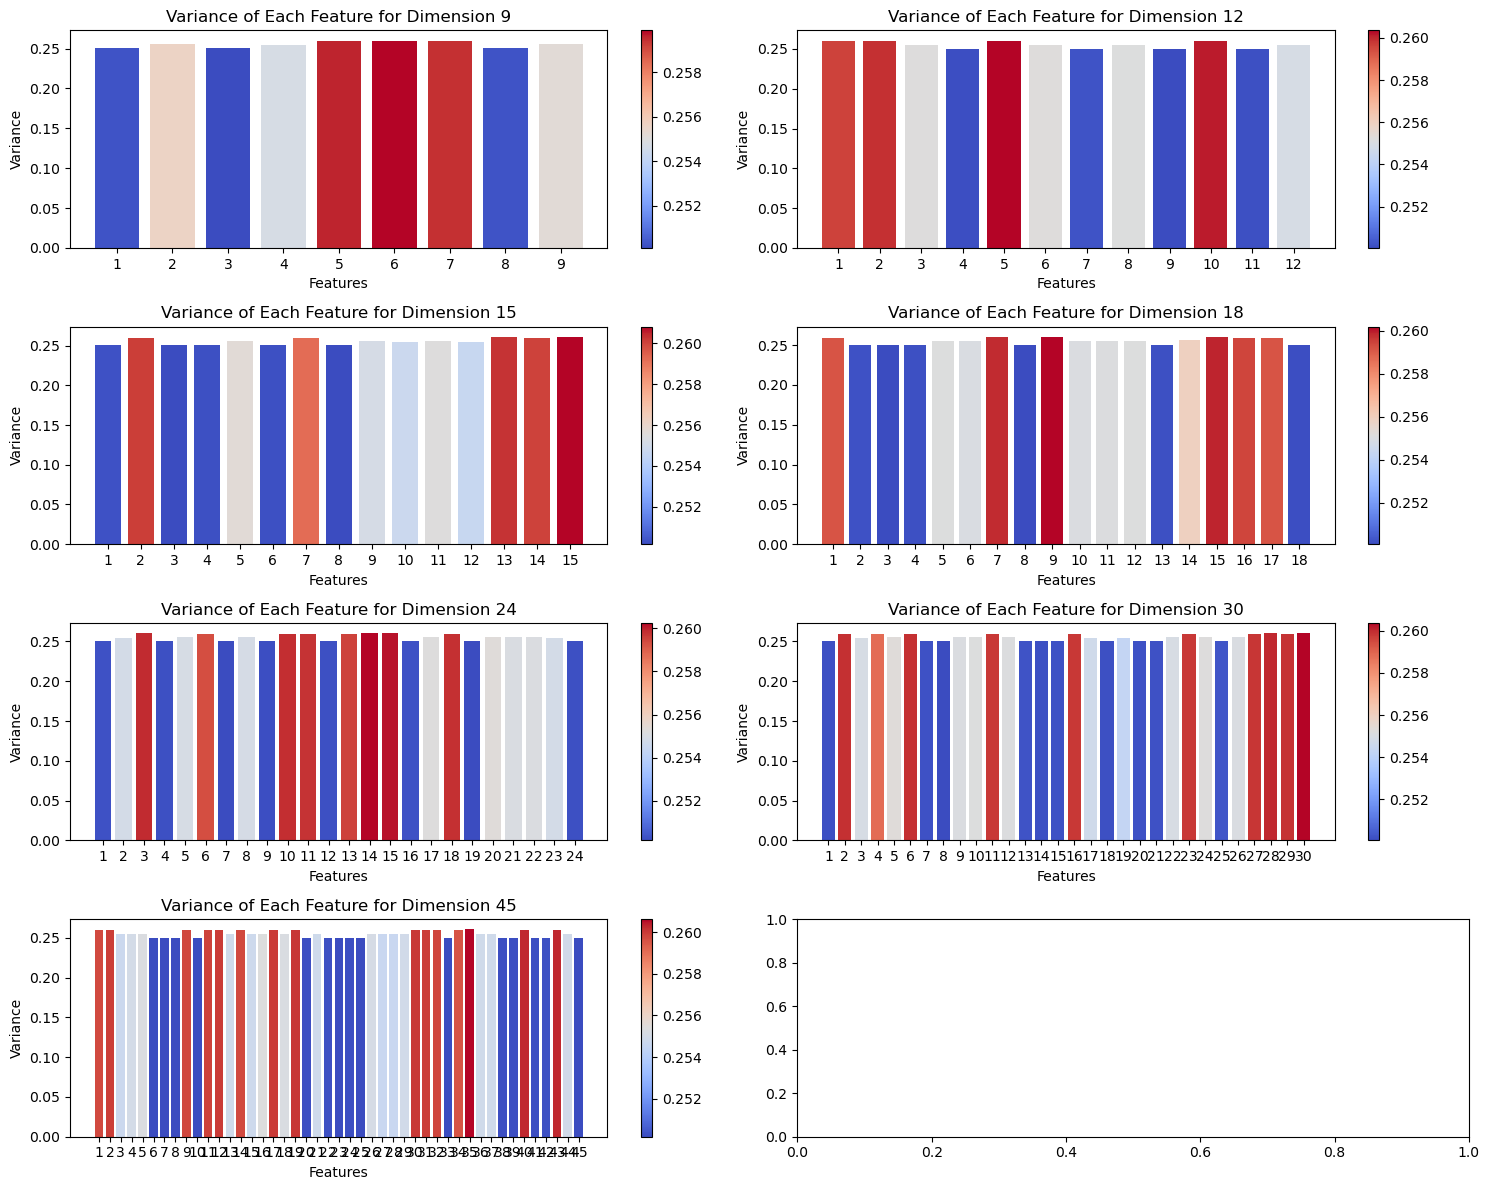

In [31]:
dimensions = [9, 12, 15, 18, 24, 30, 45]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))

axes = axes.flatten()
for i, dim in enumerate(dimensions):
    data, labels = load_data_by_dimension(dim)
    # data = scaler.fit_transform(data)
    df = pd.DataFrame(data, columns=[f"{i+1}" for i in range(data.shape[1])])
    df['Label'] = labels
    variances = df.drop('Label', axis=1).var()
    norm = plt.Normalize(variances.min(), variances.max())
    cmap = plt.get_cmap("coolwarm")
    colors = cmap(norm(variances.values))

    bars = axes[i].bar(variances.index, variances.values, color=colors)
    # axes[i].bar(variances.index, variances.values)
    axes[i].set_title(f'Variance of Each Feature for Dimension {dim}')
    axes[i].set_xlabel('Features')
    axes[i].set_ylabel('Variance')
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=axes[i])

plt.tight_layout()
plt.show()


In [30]:
def preprocess_data(data, variance_threshold):
      variances = np.var(data, axis=0)
      return data[:, variances > variance_threshold]

In [27]:
dimensions = [9, 12, 15, 18, 24, 30, 45]
axes = axes.flatten()
thresholds = [0.25,0.252,0.254,0.256,0.258]
search_grid = range(1,50,2)
results_dfs = {}

for dim in dimensions:
    data, labels = load_data_by_dimension(dim)
    
    results_list=[]
    
    for t in thresholds:
        data_processed = preprocess_data(data, variance_threshold=t)
        X_train, X_test, y_train, y_test = train_test_split(data_processed, labels, test_size=0.2, random_state=42)
        
        best_k, best_acc = find_best_knn_params(X_train, y_train, search_grid)
        
        model = KNeighborsClassifier(n_neighbors=best_k)
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        
        results_list.append([t, best_k, accuracy])
    
    results_df = pd.DataFrame(results_list, columns=["Variance Threshold", "Best K", "Accuracy"])
    results_dfs[dim] = results_df
    


for dim, df in results_dfs.items():
    print(f"Results for Dimension {dim}:")
    print(df)
    print("\n")

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)
Results for Dimension 9:
   Variance Threshold  Best K  Accuracy
0               0.250       9     0.958
1               0.252       9     0.958
2               0.254       9     0.958
3               0.256      49     0.487
4               0.258      49     0.487


Results for Dimension 12:
   Variance Threshold  Best K  Accuracy
0               0.250       1     0.921
1               0.252       9     0.966
2              

## KNN performance after feature selection

In [15]:
def plot_optimal_k(dim,K_range):
    data, labels = load_data_by_dimension(dim)
    data =  preprocess_data(data, variance_threshold=0.253)

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    accuracies_distance=[]
    accuracies=[]
    for k in krange:
        model = KNeighborsClassifier(n_neighbors=k,weights='uniform')
        model_distance = KNeighborsClassifier(n_neighbors=k,weights='distance')

        acc = cross_val_score(model, X_train, y_train, cv=5)
        acc_distance = cross_val_score(model_distance, X_train, y_train, cv=5)

        accuracies_distance.append(np.mean(acc_distance))
        accuracies.append(np.mean(acc))
    plt.rcdefaults()
    plt.figure(figsize=(10, 5))
    plt.plot(krange, accuracies, label="uniform",marker='o', linestyle='-', color='b')
    plt.plot(krange, accuracies_distance,label="distance", marker='o', linestyle='-', color='r')
    plt.ylim(0, 1) 
    plt.xlabel('Value of K')
    plt.ylabel('Accuracy')
    plt.title(f'kNN Performance for different K (dim={dim})')
    plt.legend()
    plt.grid(True)
    plt.show()

### kryptonite-9

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)


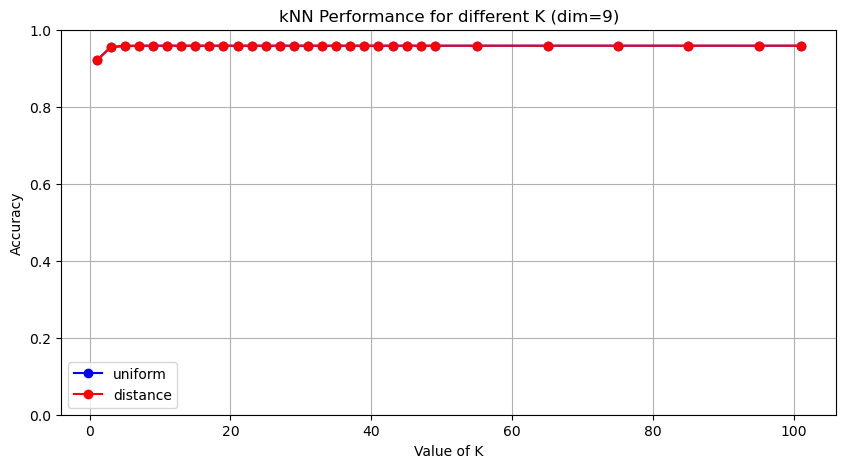

In [18]:
krange = list(range(1,50,2))+[55,65,75,85,95,101]
plot_optimal_k(9,krange)

### kryptonite-12

Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)


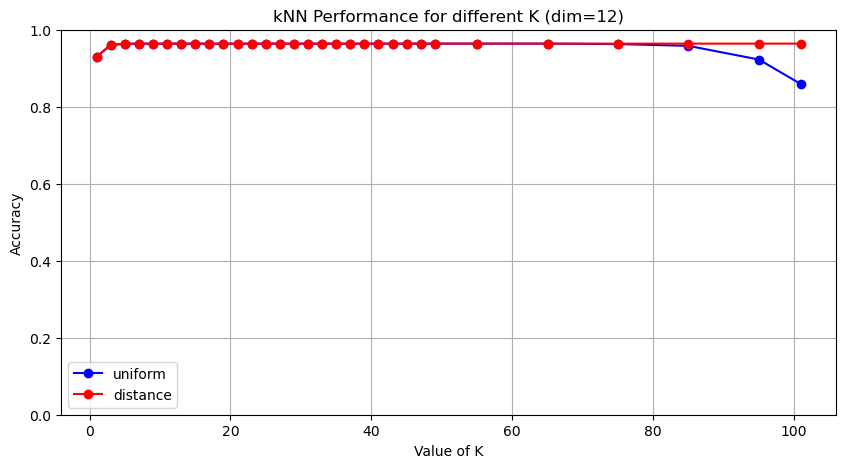

In [19]:
plot_optimal_k(12,krange)

### kryptonite-15

Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)


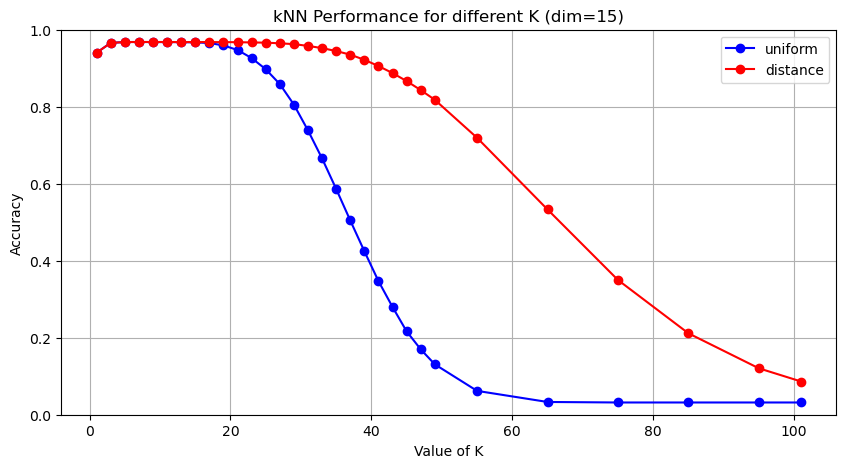

In [20]:
plot_optimal_k(15,krange)

### kryptonite-18

Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)


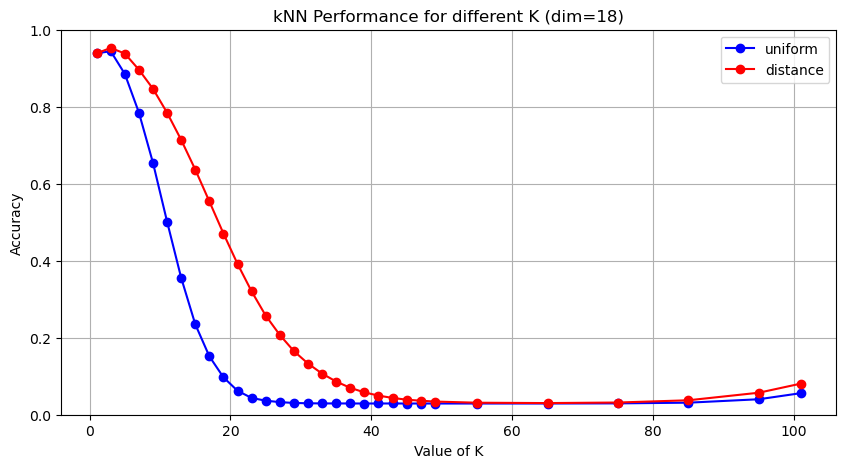

In [21]:
plot_optimal_k(18,krange)

### kryptonite-24


Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)


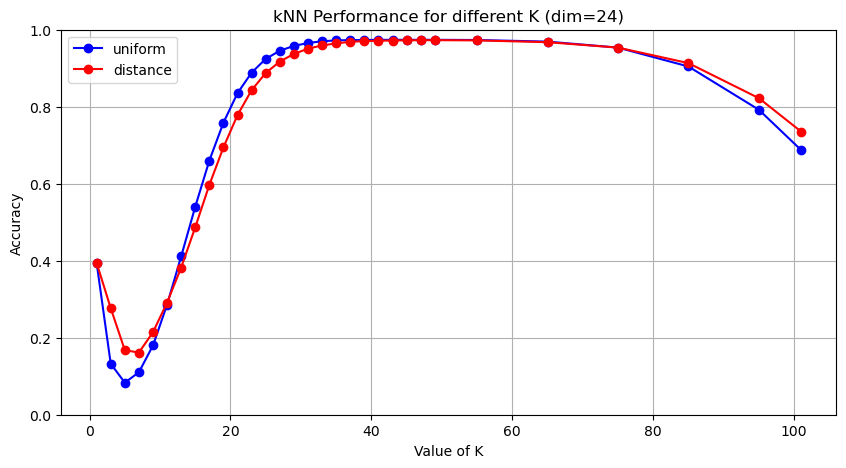

In [22]:
plot_optimal_k(24,krange)

### kryptonite-30

Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)


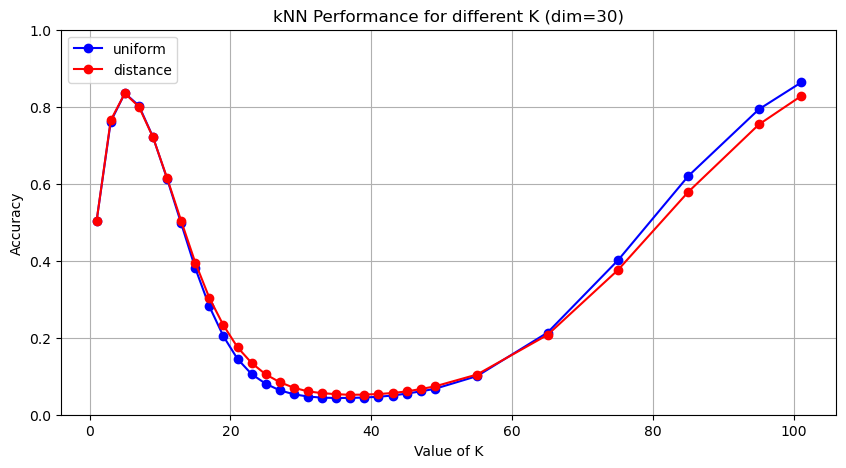

In [23]:
plot_optimal_k(30,krange) # the model basically predicts the label the datapoint is not in at k-39, thus should flip the ouput

### kryptonite-45

Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


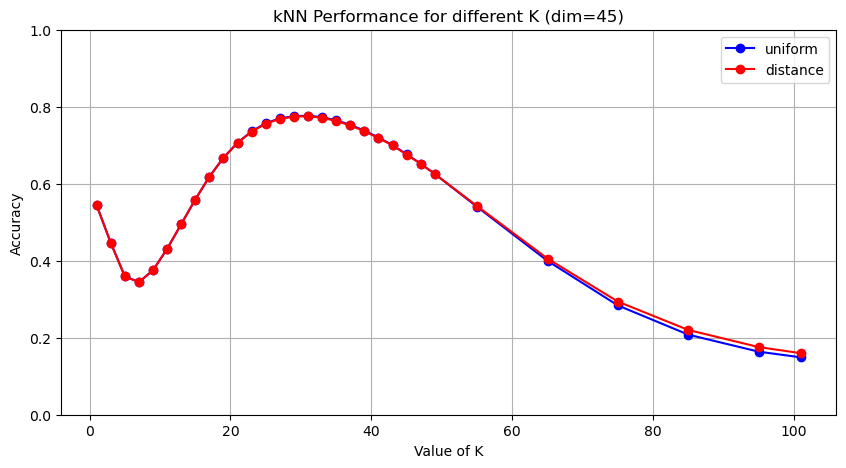

In [24]:
plot_optimal_k(45,krange)

### Evaluation

In [48]:
best_ks=[5,5,5,3,41,39,31]
means_reduction = []
std_devs_reduction = []
random_seeds = [42, 123, 456, 789, 1010, 2020, 3030, 4040, 5050, 6060]
for dim , k in zip(dimensions,best_ks):
  data, labels = load_data_by_dimension(dim)
  data = preprocess_data(data, variance_threshold=0.253)
  accuracies = []
  for seed in random_seeds:
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,random_state=seed)

    model = KNeighborsClassifier(n_neighbors=k,weights="distance")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    if dim in [30]:  # the model basically predicts the label the datapoint is not in at dim=30 and k=45, thus should flip the output
      y_pred=1-y_pred
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
  means_reduction.append(np.mean(accuracies))
  std_devs_reduction.append(np.std(accuracies))

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


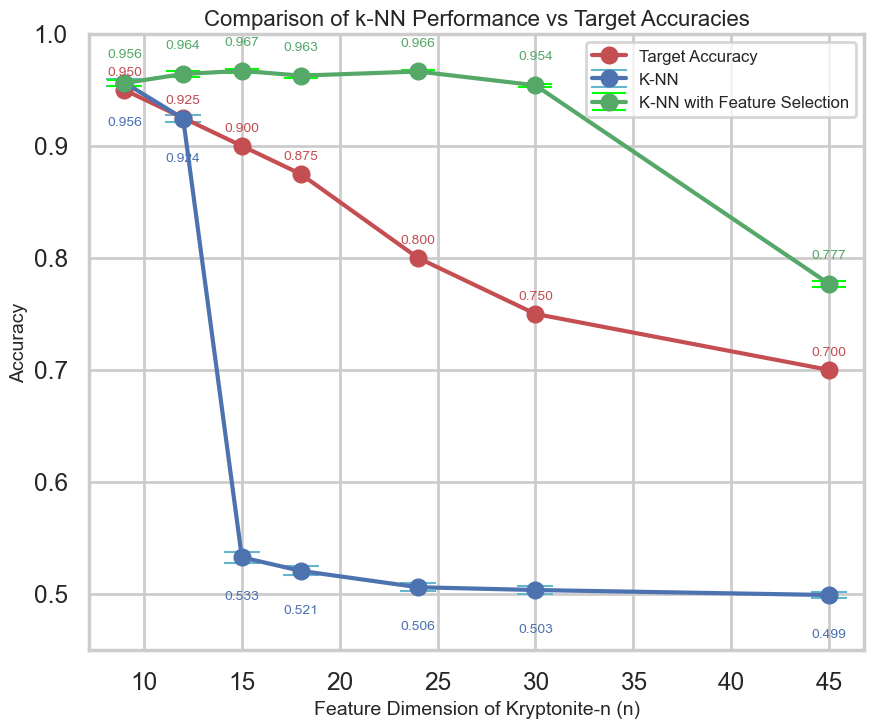

In [51]:
n = [9, 12, 15, 18, 24, 30, 45]
target_accuracies = [0.95, 0.925, 0.9, 0.875, 0.8, 0.75, 0.7]


# Plotting settings
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=0.8)
plt.figure(figsize=(10, 8))

# Plotting kNN performance
plt.errorbar(n, means, label='K-NN', yerr=std_devs, marker='o', linestyle='-', color='b', ecolor='c', capsize=12, capthick=1.5)
plt.errorbar(n, means_reduction, label='K-NN with Feature Selection', yerr=std_devs_reduction, marker='o', linestyle='-', color='g', ecolor='lime', capsize=12, capthick=1.5)

# Plotting target accuracies
plt.plot(n, target_accuracies, label='Target Accuracy', marker='o', linestyle='-', color='r')

# Annotating points for better clarity
for x, y in zip(dimensions, means):
    plt.text(x, y - 0.03, f'{y:.3f}', ha='center', va='top', color='b', fontsize=10)
for x, y in zip(dimensions, means_reduction):
    plt.text(x, y + 0.02, f'{y:.3f}', ha='center', va='bottom', color='g', fontsize=10)

for x, y in zip(n, target_accuracies):
    plt.text(x, y + 0.01, f'{y:.3f}', ha='center', va='bottom', color='r', fontsize=10)


plt.title("Comparison of k-NN Performance vs Target Accuracies", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Feature Dimension of Kryptonite-n (n)", fontsize=14)
plt.legend(fontsize=12, loc='upper right')

# Adjusting axis limits for better visual clarity
plt.ylim(0.45, 1.0)
# plt.xlim(8, 46)

# plt.tight_layout()
plt.show()


In [9]:
best_ks=[9,5,5,3,35,45,35]
dimensions=[9,12,15,18,24,30,45]
root="./datasets/"
for dim , k in zip(dimensions,best_ks):
  data, labels = load_data_by_dimension(dim)
  data = preprocess_data(data, variance_threshold=0.253)

  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(data, labels)

  data_filename = root+f'hidden-kryptonite-{dim}-X.npy'
  hidden_data = np.load(data_filename)
  hidden_data = preprocess_data(hidden_data, variance_threshold=0.253)
  y_pred = model.predict(hidden_data)
  if dim in [30]:
    y_pred=1-y_pred
  np.save(f'y_predicted_{dim}.npy', y_pred)

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)
